# Introduction

**导入库**

In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os

# Load in our libraries
import xgboost as xgb
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

# Feature Exploration, Engineering and Cleaning

特征探索，工程和清理

Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

现在我们将进行如同大多数内核的结构一样，那就是首先探索手头的数据，确定可能的特征工程机会以及对任何分类特征进行数字编码。

In [2]:
# Load in the train and test datasets
# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/test.csv')

# Load in the train and test datasets
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Well it is no surprise that our task is to somehow extract the information out of the categorical variables

我们的任务就是从分类变量中提取信息，这并不奇怪。

**Feature Engineering**

**特征工程**

Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work

在这里，归功于必须扩展到Sina的功能工程理念非常全面和深思熟虑的笔记本，所以请查看他的工作。

Titanic Best Working Classfier（https://www.kaggle.com/sinakhorami/titanic-best-working-classifier?scriptVersionId=566580）: by Sina 

In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
# 我自己添加的一些特征给出了名称的长度
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
# 这一特征告诉我们乘客在泰坦尼克号上是否有船舱。注意：type(train["Cabin"][0])是浮点类型。
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
# 从新浪的特色工程步骤中，创建了新的特色家庭规模，作为SibSp和Parch的结合。
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
# 根据家庭大小创建新功能
# .LOc:根据元素的选取条件来选取对应的数据
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Remove all NULLS in the Embarked column
# 删除Embarked列中的所有NULLS
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
# 删除Fare列中的所有NULLS并创建一个新功能CategoricalFare
# .qcut:是根据出现的频率，把一列数据分成四类，四个区间，当然多少个区间可以设置。
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
# 创建一个新的特性分类。
# isnull().sum(),是检查每行为空的空格后，让age_null_count = 1，为了生成随机数；
# np.random.randint，返回是一个数组；
# np.isnan()，是检查每行有空的话，就赋值随机生成的值；
# .astype(int)，是转型值为整数类型；
# pd.cut,是根据值本身来选择箱子均匀间隔。
for dataset in full_data:
    age_avg = dataset['Age'].mean() #求平均值
    age_std = dataset['Age'].std()  #求标准偏差
    age_null_count = dataset['Age'].isnull().sum() #计算所有空的列数
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count) # 标准差的随机值；
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list #如果有空就赋值
    dataset['Age'] = dataset['Age'].astype(int) #转换值为整数类型
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract titles from passenger names
# 定义从乘客名称中提取标题的功能
# re.search,是找到A-Za-z.的字符，具体看：https://www.cnblogs.com/tina-python/p/5508402.html
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    # 如果标题存在，提取并返回它。
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
# 创建一个新的特性标题，包含乘客姓名的标题。
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
# 将所有非通用标题分组成一个“罕见”的分组
# replace，替换你要换的值dataform.replacd（放你要换的值，换什么值）
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    

for dataset in full_data:
    # Mapping Sex,将性别换成0和1,并转换为整型
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles，将姓名换成1,2,3,4,5,其他用0填充
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked,将字符换成0,1,2，并转换为整型
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare,把四个区间分成换成：0,1,2,3，并转换为整型
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age，把年龄的五个区间换成0,1,2,3,4
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] 					       = 4

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [4]:
# Feature selection
# 删除五个特征。
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

好吧，现在已经清理了这些功能并提取了相关信息，并删除了分类列，我们的功能现在应该都是数字的，这是一种适合我们的机器学习模型的格式。 然而，在我们继续之前，让我们生成一些简单的相关性和我们转换数据集的分布图来观察ho

# Visualisations

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


**Pearson Correlation Heatmap**

**皮尔森相关的热图**

let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows.

让我们生成一些特性的相关图，以了解一个特性与下一个特性之间的关系。为了做到这一点，我们将利用Seaborn的绘图软件包，使我们可以非常方便地绘制热图，如下图所示。

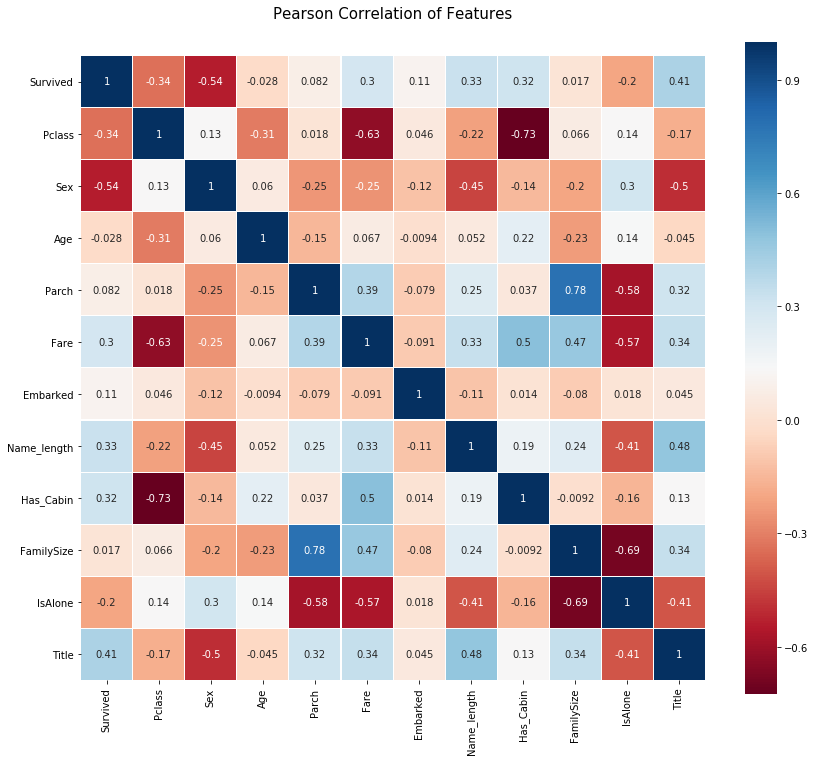

In [6]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
colormap = plt.cm.RdBu

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

**Takeaway from the Plots**

**从情节中提取**

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch (Parents and Children). I'll still leave both features in for the purposes of this exercise.

皮尔逊相关图能告诉我们的一件事是，没有太多的特征是紧密相关的。从将这些特性引入到您的学习模型中，这是很好的，因为这意味着在我们的训练集中没有太多冗余或多余的数据，而且我们很高兴每个特性都带有一些独特的信息。这里有两个最相关的特征是家庭规模和父母和孩子。为了进行这个练习，我仍然保留这两个特性。

**Pairplots**

**配对图**

Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.

最后，让我们生成一些配对图来观察数据从一个特性到另一个特性的分布。我们再一次使用Seaborn来帮助我们。

hue='Survived'： 使用指定变量为分类变量画图；

palette : 调色板颜色；

size : 默认6，图的尺度大小（正方形）

diag_kind = 'kde'：改变对角图为抛物线图；

{plot, diag, grid}_kws：指定其他参数。参数类型：dicts；

kind="reg"：使用回归；

详细：https://www.jianshu.com/p/6e18d21a4cad

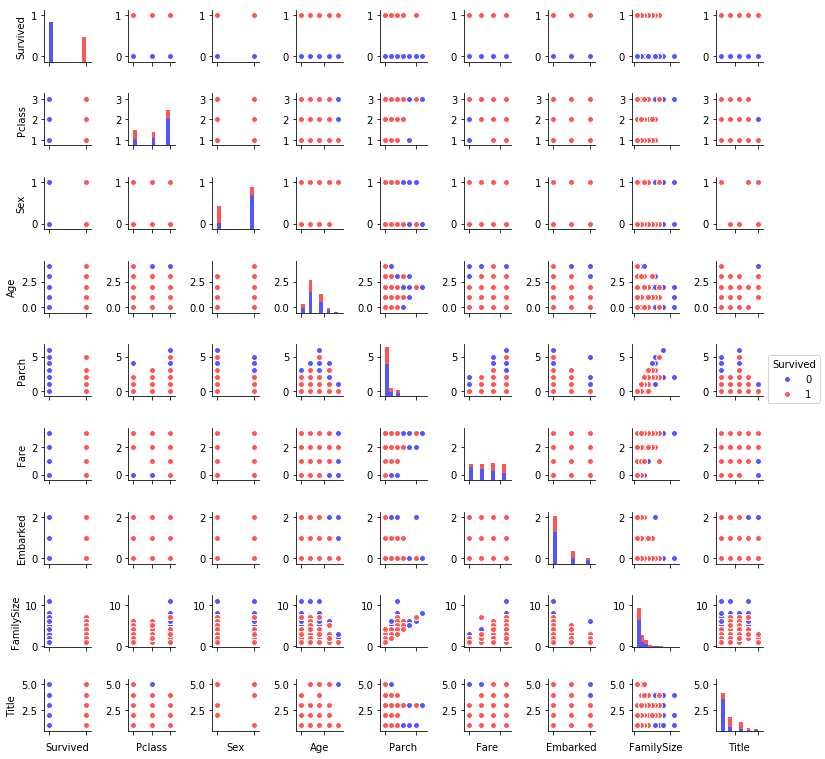

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2)
g.set(xticklabels=[])

**Ensembling & Stacking models**

**整合和堆叠模型**

Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.

最后，在简短的旋风之后，我们终于看到了这个笔记本的精髓和要点。

Creating a Stacking ensemble!

创建堆叠合奏！

**Helpers via Python Classes**

**Helpers通过Python类**

Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.

在这里，我们调用Python类的用法，以帮助我们更方便地使用它。对于任何新编程的新手来说，通常会听到与面向对象编程(OOP)一起使用的类。简而言之，一个类有助于扩展一些用于创建对象的代码/程序(为老派的peeps提供变量)，以及实现特定于该类的函数和方法。

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

在下面的代码部分中，我们实际上编写了一个类SklearnHelper，它允许一个人将内置的方法(例如训练、预测和匹配)扩展到所有的Sklearn分类器中。因此，如果我们想要调用5个不同的分类器，就不需要5次编写相同的方法。

In [8]:
# Some useful parameters which will come in handy later on
# 一些有用的参数稍后将派上用场。
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility 重现性
NFOLDS = 5 # set folds for out-of-fold prediction 设置折叠以进行折叠预测
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier 类扩展Sklearn分类器。
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer 类扩展XGboost分类器。

Bear with me for those who already know this but for people who have not created classes or objects in Python before, let me explain what the code given above does. In creating my base classifiers, I will only use the models already present in the Sklearn library and therefore only extend the class for that.

对于那些已经知道这一点但对于那些以前没有在Python中创建过类或对象的人来说，请允许我解释上面给出的代码的作用。 在创建我的基础分类器时，我只会使用已经存在于Sklearn库中的模型，因此只能扩展该类。

**def init** : Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you want), seed (random seed) and params (parameters for the classifiers).

**def init**:用于调用类的默认构造函数的Python标准。这意味着当您想要创建一个对象(分类器)时，您必须给它提供clf的参数(您想要的sklearn分类器)、种子(随机种子)和params(分类器的参数)。

The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. Essentially, we have created a wrapper class to extend the various Sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker.

其余的代码只是简单地调用sklearn分类器中已有的相应方法的类的方法。 实质上，我们创建了一个包装类来扩展各种Sklearn分类器，以便在我们将多个学习器实现到我们的堆栈器时，这将有助于减少必须反复编写相同的代码。

**Out-of-Fold Predictions**

**Out-of-Fold预测**

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

现在正如在前面部分中提到的那样，堆叠使用基础分类器的预测作为对第二级模型的训练的输入。 然而，不能简单地在完整训练数据上训练基础模型，在完整测试集上产生预测，然后输出这些用于第二级训练。 这会带来基本模型预测已经“看到”测试集并因此在馈送这些预测时过度拟合的风险。

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

**Generating our Base First-Level Models**

**生成基本的一级模型**

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

现在让我们准备5个学习模型作为我们的第一级分类。这些模型都可以通过Sklearn库方便地调用，并列出如下:

Random Forest classifier；
Extra Trees classifier；
AdaBoost classifer；
Gradient Boosting classifer；
Support Vector Machine。

随机森林分类器

额外的数分离器

集成分类器

梯度增强分类器

支持向量机

**Parameters**

**参数**

Just a quick summary of the parameters that we will be listing here for completeness,

简单总结一下我们将在这里列出的参数的完整性，

**n_jobs** : Number of cores used for the training process. If set to -1, all cores are used.

**n_jobs** ：用于训练过程的CPU核心数量。 如果设置为-1，则使用所有CPU内核。

**n_estimators** : Number of classification trees in your learning model ( set to 10 per default)

**n_estimators** :学习模型中分类树的数量(默认设置为10)

**max_depth** : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep。

**max_depth** :树的最大深度，或者一个节点应该扩展多少。如果设置的数值过高会导致过度拟合的风险，因为这样会使树长得太深。

**verbose** : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

**verbose** : 控制在学习过程中是否要输出任何文本。一个值为0，可以抑制所有文本，而一个值为3，在每次迭代中输出树的学习过程。

Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.

请通过官方的Sklearn网站查看完整的描述。在那里你会发现有很多其他有用的参数你可以玩。

In [10]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

此外，既然已经提到了OOP框架中的对象和类，现在让我们创建5个对象，它们通过我们前面定义的帮助器Sklearn类来表示我们的5个学习模型。

In [11]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**Creating NumPy arrays out of our train and test sets**

**从我们的训练集和测试集中创建NumPy数组**

Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

太好了。我们已经准备好了我们的第一个层基础模型，现在我们可以通过生成NumPy阵列来为我们的分类器提供输入的训练和测试测试数据，如下所示:

In [12]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
# 创建Numpy阵列的训练集、测试集和目标(幸存)数据，以满足我们的模型。
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

**Output of the First level Predictions**

**第一级预测的输出**

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

我们现在将训练和测试数据输入到我们的5个基本分类器中，并使用之前定义的Out-of-Fold预测函数来生成我们的第一级预测。 允许几分钟的时间运行下面的代码块。

In [13]:
# Create our OOF train and test predictions. These base results will be used as new features
# ＃创建我们的OOF训练和测试预测。 这些基础结果将用作新功能
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



Training is complete


**Feature importances generated from the different classifiers**

**从不同的分类器中产生的特征输入。**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

现在学习了我们的第一级分类器，我们可以利用Sklearn模型的一个非常漂亮的特性，即用一行非常简单的代码输出训练和测试集中各种特性的重要性。

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.featureimportances**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

根据Sklearn文档，大多数分类器都内置了一个属性，只需输入**feature_importances**即可返回特征的重要性。 因此，我们将通过我们的函数earliand来调用这个非常有用的属性，并将特征重要性绘制成这样:

In [14]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



[ 0.12737225  0.20073307  0.02951727  0.02154504  0.0710161   0.02389766
  0.11156092  0.06420601  0.066311    0.01345599  0.27038468]
[ 0.11915406  0.38240779  0.02774568  0.01773231  0.05632617  0.02826762
  0.04721441  0.08337743  0.04379294  0.02204729  0.1719343 ]
[ 0.03   0.012  0.014  0.07   0.038  0.01   0.68   0.014  0.054  0.002
  0.076]
[ 0.07205526  0.02902909  0.12549896  0.03166549  0.09207622  0.04028585
  0.40344759  0.02086383  0.07799769  0.02541332  0.08166669]


So I have not yet figured out how to assign and store the feature importances outright. Therefore I'll print out the values from the code above and then simply copy and paste into Python lists as below (sorry for the lousy hack)

因此，我还没有弄清楚如何直接分配和存储该特征。因此，我将从上面的代码中打印出这些值，然后简单地将其复制粘贴到Python列表中，如下所示(对糟糕的hack感到抱歉)

In [15]:
rf_features = [0.12746687, 0.19951398, 0.03046947, 0.02128995, 0.07242905, 0.02431925, 
               0.10758511, 0.06394576, 0.06655668, 0.01338177, 0.27304212]
et_features = [0.12025725, 0.38143788, 0.02927734, 0.01694035, 0.05564963, 0.02881491, 
               0.04758752, 0.0832991, 0.04482401, 0.02167239, 0.17023964]
ada_features = [0.028, 0.01, 0.016, 0.06, 0.038, 0.01, 0.7, 0.012, 0.048, 0.004, 0.074]
gb_features = [0.07069232, 0.0334993, 0.08639371, 0.03233732, 0.10618982, 0.06994133, 
               0.40819726, 0.01742999, 0.06512816, 0.01578308, 0.09440772]

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

从包含功能重要性数据的列表中创建一个dataframe，以便通过简单的包进行简单的绘图。

In [16]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [17]:
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features
0,0.028,0.120257,0.070692,0.127467,Pclass
1,0.010,0.381438,0.033499,0.199514,Sex
2,0.016,0.029277,0.086394,0.030469,Age
3,0.060,0.016940,0.032337,0.021290,Parch
4,0.038,0.055650,0.106190,0.072429,Fare
5,0.010,0.028815,0.069941,0.024319,Embarked
6,0.700,0.047588,0.408197,0.107585,Name_length
7,0.012,0.083299,0.017430,0.063946,Has_Cabin
8,0.048,0.044824,0.065128,0.066557,FamilySize
9,0.004,0.021672,0.015783,0.013382,IsAlone


**Interactive feature importances via Plotly scatterplots**

**通过巧妙的散点图进行交互特征输入。**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers via a plotly scatter plot by calling "Scatter" as follows:

在这个时候，我将使用交互式的Plotly包，通过一个粗略的散点图，将不同的分类器的特征输入值可视化，并将其称为“散点”:

In [21]:
# Scatter plot ：Random Forest feature importances
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True),text = feature_dataframe['features'].values)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),showlegend= False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot ：Extra Trees  feature importances
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot ：'AdaBoost feature importances
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot ：Gradient Boost feature importances
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe.

现在，让我们计算所有特征的平均值，并将其作为一个新列存储在特征的重要性dataframe中。

In [22]:
# Create the new column containing the average of values
# 创建包含平均值的新列。

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.028,0.120257,0.070692,0.127467,Pclass,0.086604
1,0.010,0.381438,0.033499,0.199514,Sex,0.156113
2,0.016,0.029277,0.086394,0.030469,Age,0.040535


**Plotly Barplot of Average Feature Importances**
**Plotly平均特征重要性的Barplot**

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:
获得了所有分类器的平均特征重要性后，我们可以将它们绘制成Plotly条形图，如下所示：

In [23]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

**First-level output as new features**

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

现在已经获得了我们的第一级预测，我们可以把它看作是构建一组新的特性，作为下一个分类器的训练数据。根据下面的代码，我们将我们的新列作为我们早期分类器的第一级预测，并在此基础上训练下一个分类器。

In [24]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


**Correlation Heatmap of the Second Level Training set**

**第二层次训练集的相关热图。**

In [25]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

有不少文章和Kaggle比赛冠军的故事讲述了训练有素的模型的优点，这些模型彼此之间更不相关，从而获得更好的分数。

In [26]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

现在已经连接并加入了第一级的训练和测试预测，如x_train和x_test，现在我们可以使用一个二级学习模型。

**Second level learning model via XGBoost**

**通过XGBoost进行二级学习。**

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the official documentation.

在这里，我们选择了一个非常有名的库，用于提升树的学习模型，XGBoost。它是为了优化大规模的提升树算法而建立的。有关该算法的进一步信息，请查阅官方文档。https://xgboost.readthedocs.io/en/latest/

这里有详细解析XGBoost原理：https://xgboost.readthedocs.io/en/latest/get_started/

以下这个网页对GB进行了极其badass的可视化:
http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html

更可以了解"加强版" Gradient Boost---ＸGBoost
http://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

如何开始着手解决一个机器学习问题? 如何选择模型? sklearn的算法地图清晰地指导你应该怎么开始:
http://scikit-learn.org/stable/tutorial/machine_learning_map/

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

无论如何，我们调用XGBClassifier并将其与第一级的训练和目标数据相匹配，并使用学习模型来预测测试数据如下:

In [31]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 2000, max_depth= 4,
    min_child_weight= 2, #gamma=1,
    gamma=0.9, subsample=0.8,
    colsample_bytree=0.8, objective= 'binary:logistic',
    nthread= -1,scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

Just a quick run down of the XGBoost parameters used in the model:

只需快速浏览一下模型中使用的XGBoost参数:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**max_depth** : 你想要多深的树。如果设置过高的数字可能会导致过度拟合的风险。

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**gamma** : 为了在树的叶子节点上做进一步的划分，需要减少最小损失。算法越大，算法就越保守。


**eta** : step size shrinkage used in each boosting step to prevent overfitting

**eta** :  步长收缩，用于每一个提升步骤，以防止过度拟合。

**Producing the Submission file**

**生产提交文件**

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

最后，我们训练并适应了所有的一级和二级模型，现在我们可以将预测输出到正确的格式，提交到《泰坦尼克号》的比赛中:

In [ ]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

**Steps for Further Improvement**

**进一步改善的步骤**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels.

作为结束语，必须指出的是，上面所采取的步骤只是展示了一种生产集成式堆垛机的非常简单的方法。 你会听到在Kaggle比赛的最高级别上创作的乐团，这些比赛涉及堆叠分类器的怪异组合，以及堆叠级别超过2级。

Some additional steps that may be taken to improve one's score could be:

可以采取一些额外的措施来提高一个人的分数:

1.Implementing a good cross-validation strategy in training the models to find optimal parameter values。

2.Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.

1。在训练模型中实现一个好的交叉验证策略以找到最优的参数值。

2。介绍更多的学习基础模型。结果越不相关，最终得分越好。

**Conclusion**

**结论**

I have this notebook has been helpful somewhat in introducing a working script for stacking learning models. Again credit must be extended to Faron and Sina.

我有这个笔记本，在介绍一种用于堆叠学习模型的工作脚本时，有所帮助。同样的，归功于Faron和Sina。

For other excellent material on stacking or ensembling in general, refer to the de-facto Must read article on the website MLWave: Kaggle Ensembling Guide.

其他关于堆叠或合奏的优秀材料，请参考网站MLWave: Kaggle套装指南上的文章。（https://mlwave.com/kaggle-ensembling-guide/）

Till next time, Peace Out

直到下一次，和平结束。

**查看字段缺失情况**

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int32
Age            891 non-null int32
Parch          891 non-null int64
Fare           891 non-null int32
Embarked       891 non-null int32
Name_length    891 non-null int64
Has_Cabin      891 non-null int64
FamilySize     891 non-null int64
IsAlone        891 non-null int64
Title          891 non-null int64
dtypes: int32(4), int64(8)
memory usage: 69.7 KB


In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
Pclass         418 non-null int64
Sex            418 non-null int32
Age            418 non-null int32
Parch          418 non-null int64
Fare           418 non-null int32
Embarked       418 non-null int32
Name_length    418 non-null int64
Has_Cabin      418 non-null int64
FamilySize     418 non-null int64
IsAlone        418 non-null int64
Title          418 non-null int64
dtypes: int32(4), int64(7)
memory usage: 29.5 KB


**人工选取对预测有效的特征：**

In [5]:
selected_features=['Pclass', 'Sex','Age','Embarked','SibSp','Parch','Fare']

In [6]:
X_train = train[selected_features]
X_test = test[selected_features]

In [7]:
y_train=train['Survived']

**填补Embarked特征存在的缺失值。**

In [8]:
X_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
X_test['Embarked'].value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

**我们使用出现频率最高的特征值来填充。**

In [10]:
X_train['Embarked'].fillna('S',inplace=True)
X_test['Embarked'].fillna('S',inplace=True)

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


**用平均值填充Age的缺失值。**

In [11]:
X_train.fillna(X_train.mean()['Age'], inplace=True)
X_test.fillna(X_test.mean()['Age':'Fare'], inplace=True)

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
Embarked    891 non-null object
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 48.8+ KB


In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         418 non-null float64
Embarked    418 non-null object
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 22.9+ KB


**采用DictVectorizer对特征向量化**

In [14]:
from sklearn.feature_extraction import DictVectorizer
dict_vec = DictVectorizer(sparse=False)
X_train = dict_vec.fit_transform(X_train.to_dict(orient='record'))
dict_vec.feature_names_

['Age',
 'Embarked=C',
 'Embarked=Q',
 'Embarked=S',
 'Fare',
 'Parch',
 'Pclass',
 'Sex=female',
 'Sex=male',
 'SibSp']

In [15]:
X_test = dict_vec.transform(X_test.to_dict(orient='record'))

**我将使用以下机器学习模型来训练：**
- Logistic Regression（逻辑回归）
- KNN or k-Nearest Neighbors（K近邻）
- Support Vector Machines（支持向量机）
- Naive Bayes classifier（朴素贝叶斯）
- Decision Tree（决策树）
- Random Forrest（随机森林）
- Perceptron（感知机）
- Artificial neural network（人工神经网络）
- RVM or Relevance Vector Machine（相关向量机）

**从sklearn.linear_model中导入Logistic Regression**

使用默认初始化的Logistic Regression.

In [25]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [27]:
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

80.359999999999999

**从sklearn.svm中导入SVC**

使用默认初始化的SVC.

In [28]:
from sklearn.svm import SVC
svc = SVC()

In [30]:
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

89.0

**从sklearn.neighbors中导入KNeighborsClassifier**

使用默认初始化的KNeighborsClassifier.

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)

In [32]:
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

83.609999999999999

**从sklearn.naive_bayes中导入GaussianNB**

使用默认初始化的KNeighborsClassifier.

In [34]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()

In [35]:
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

79.120000000000005

**从sklearn.linear_model中导入Perceptron**

使用默认初始化的Perceptron.

In [36]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron()

In [37]:
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


67.900000000000006

**从sklearn.svm中导入LinearSVC**

使用默认初始化的LinearSVC.

In [38]:
from sklearn.svm import LinearSVC
linear_svc = LinearSVC()

In [39]:
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

68.689999999999998

**从sklearn.linear_model中导入SGDClassifier**

使用默认初始化的SGDClassifier.

In [40]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()

In [42]:
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


63.75

**从sklearn.tree中导入DecisionTreeClassifier**

使用默认初始化的DecisionTreeClassifier.

In [43]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

In [44]:
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

98.200000000000003

**从sklearn.ensemble中导入RandomForestClassifier**

使用默认初始化的RandomForestClassifier.

In [48]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)

In [49]:
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

98.200000000000003

**从流行工具包xgboost导入XGBClassifier用于处理分类预测问题。**

也使用默认配置初始化XGBClassifier。

In [60]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()

In [61]:
xgbc.fit(X_train, y_train)
Y_pred = xgbc.predict(X_test)
acc_xgbc = round(xgbc.score(X_train, y_train) * 100, 2)
acc_xgbc

87.209999999999994

**所有机器学习模型评分打印为表格并从大到小排序。**

In [76]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Xgboost'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_xgbc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,98.20
8,Decision Tree,98.20
0,Support Vector Machines,89.00
9,Xgboost,87.21
1,KNN,83.61
2,Logistic Regression,80.36
4,Naive Bayes,79.12
7,Linear SVC,68.69
5,Perceptron,67.90
6,Stochastic Gradient Decent,63.75


**使用五折交叉验证的方法在训练集上分别对所有机器学习模型进行性能评估，并获得平均分类准确性的得分。**

In [ ]:
from sklearn.cross_validation import cross_val_score

In [53]:
cross_val_score(logreg, X_train, y_train, cv=5).mean()

0.79128522828142689

In [54]:
cross_val_score(svc, X_train, y_train, cv=5).mean()

0.71398254549013807

In [55]:
cross_val_score(knn, X_train, y_train, cv=5).mean()

0.70932382481371825

In [56]:
cross_val_score(gaussian, X_train, y_train, cv=5).mean()

0.78903147649095495

In [57]:
cross_val_score(perceptron, X_train, y_train, cv=5).mean()

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Anaconda3\envs\tensorflow-gpu\lib\sit

0.60247820136769192

In [58]:
cross_val_score(linear_svc, X_train, y_train, cv=5).mean()

0.64332642855648314

In [59]:
cross_val_score(sgd, X_train, y_train, cv=5).mean()

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Anaconda3\env

0.69482464455648596

In [51]:
cross_val_score(random_forest, X_train, y_train, cv=5).mean()

0.81712820862001279

In [52]:
cross_val_score(xgbc, X_train, y_train, cv=5).mean()

0.81824559798311003

**使用默认配置的RandomForestClassifier进行预测操作。**

In [62]:
random_forest.fit(X_train, y_train)
random_forest_y_predict = random_forest.predict(X_test)
random_forest_submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':random_forest_y_predict})

**将默认配置的RandomForestClassifier对测试数据的预测结果存续在文件rfc_submission.csv中。**

In [63]:
random_forest_submission.to_csv('./random_forest_submission.csv', index=False)

使用默认配置的XGBClassifier进行预测操作。

In [67]:
xgbc.fit(X_train, y_train)
xgbc_y_predict = xgbc.predict(X_test)

将默认配置的XGBClassifier对测试数据的预测结果存续文件xgbc_submission.csv中。

In [68]:
xgbc_submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':xgbc_y_predict})
xgbc_submission.to_csv('./xgbc_submission.csv', index=False)

**使用并行网格搜索的方式寻找更好的超参数组合，以期待进一步提高XGBClassifier的预测性能。**

In [69]:
from sklearn.grid_search import GridSearchCV
params = {'max_depth': [2, 3, 4, 5, 6, 7], 
          'n_estimators': [100, 200, 300, 400, 500, 600]}

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [70]:
xgbc_best = XGBClassifier()
gs = GridSearchCV(xgbc_best, params, n_jobs=-1, cv=5, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7], 'n_estimators': [100, 200, 300, 400, 500, 600]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

**查验优化之后的XGBClassifier的超参数配置以及交叉验证的准确性。**

In [71]:
print(gs.best_score_)
print(gs.best_params_)

0.835016835016835
{'max_depth': 5, 'n_estimators': 100}


**使用经过优化超参数配置的XGBClassifier对测试数据的预测结果存储在文件xgbc_best_submission.csv中。**

In [72]:
xgbc_best_y_predict = gs.predict(X_test)
xgbc_best_submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':xgbc_best_y_predict})
xgbc_best_submission.to_csv('./xgbc_best_submission.csv', index=False)